# 1. Import

## 1.1 Necessary libraries

In [1]:
import torch
from torch import nn  # nn contains all of PyTorch's building blocks for NNs
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   # visualization

import argparse
import sys

# progress tracking
from tqdm import tqdm
from timeit import default_timer as timer 

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

# 1.2 Auxiliary functions

In [2]:
from utils import print_train_time, train_step, validation_step
from utils import EarlyStopping

# 2. Settings

## 2.1 Hyperparamter setting

In [3]:

parser = argparse.ArgumentParser(description='Hyperparameters for model training')
parser.add_argument('--batch_size', 
                    default=32,
                    metavar='B', 
                    type=int,
                    help='number of samples per batch')
parser.add_argument('--learning_rate', 
                    default=0.001,
                    metavar='lr',
                    type=float,
                    help='learning rate for optimizer ')
parser.add_argument('--num_epoch', 
                    default=200,
                    metavar='N',
                    type=int,
                    help='number of epoch to train the model for')
parser.add_argument('--generation_kwargs', 
                    default={'augmentation_factor' : 1},
                    metavar='GenKw',
                    type=dict,
                    help='**kwargs used in training dataset generation')
parser.add_argument('--use_weighted_loss', 
                    default=True,
                    metavar='WL',
                    type=bool,
                    help='variable to whether use weighted loss function or not ')
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]
args = parser.parse_args()
args.num_epoch

200

## 2.2 Device agnostic code

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


# 3. Data: Preparation & train-test split

In [5]:
from dataset import generate_training_dataset
train_inputs, train_outcomes, test_inputs, test_outcomes = generate_training_dataset(**args.generation_kwargs) # val_inputs, val_outcomes, 

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


## 3.2 Create PyTorch Dataset

In [6]:
class ReactifyDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.from_numpy(inputs)
        self.labels = torch.from_numpy(labels).argmax(dim=1)
        self.classes = torch.unique(self.labels).tolist()
    def __len__(self): return len(self.inputs)
    def __getitem__(self, index): 
        input = self.inputs[index]
        label = self.labels[index] 
        return input, label
train_dataset = ReactifyDataset(inputs=train_inputs, labels=train_outcomes)
# val_dataset = ReactifyDataset(inputs=val_inputs, labels=val_outcomes)
test_dataset = ReactifyDataset(inputs=test_inputs, labels=test_outcomes)

print(f"length of training dataset: {len(train_dataset)}")  
# print(f"length of validation dataset: {len(val_dataset)}")  
print(f"length of test dataset: {len(test_dataset)}")  
print(f"classes: {train_dataset.classes}")  

length of training dataset: 444
length of test dataset: 1018
classes: [0, 1, 2, 3]


## 3.3 Visualize

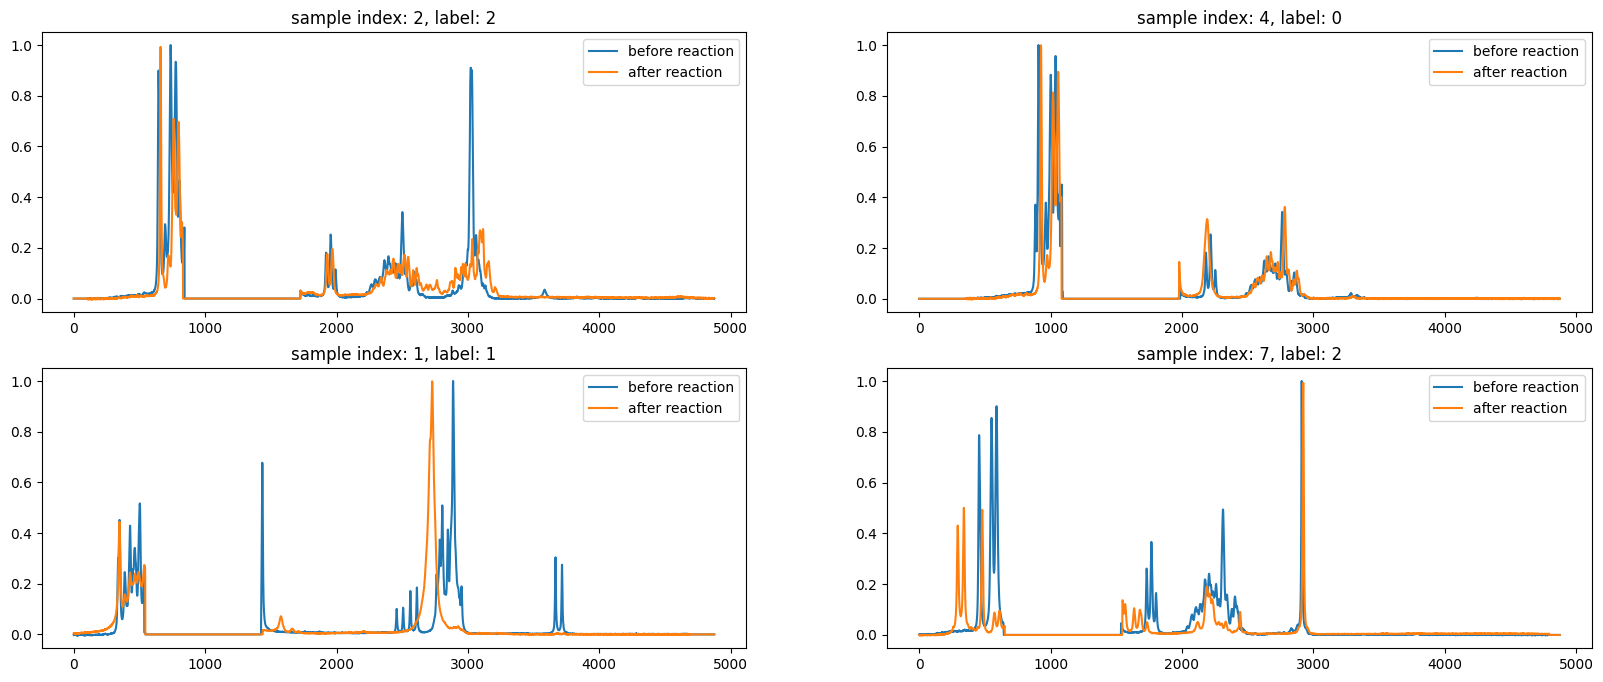

In [7]:
from math import ceil
num_samples = 4
sample_indices = np.random.choice(a=10 , size=num_samples, replace=False)  # choose num_samples number of data points
n_rows = ceil(num_samples / 2)
n_cols = 2
plt.figure(figsize=(20,8))
for i, sample_idx in enumerate(sample_indices):
    sample_input, sample_label = train_dataset[sample_idx]
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(sample_input[0], label='before reaction')
    plt.plot(sample_input[1], label = 'after reaction')
    plt.title(f"sample index: {sample_idx}, label: {sample_label}")
    plt.legend()

### 3.2.1 See shapes

In [8]:
print(f"input shape: {train_dataset.inputs[0].shape}")  # (2 x spectrum_length)
print(f"label shape: {train_dataset.labels[0].shape}")  # scalar integer depicting class value among {0,1,2,3}

input shape: torch.Size([2, 4876])
label shape: torch.Size([])


## 3.3 Create PyTorch DataLoader

In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
# val_loader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=False) 
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=False)

train_inputs_batch, train_labels_batch = next(iter(train_loader))
print(f"batch input shape: {train_inputs_batch.shape}")   # batch_size x 2 x spectrum_length
print(f"batch label shape: {train_labels_batch.shape}")   # batch_size,

batch input shape: torch.Size([32, 2, 4876])
batch label shape: torch.Size([32])


# 4. MOLE

## 4.1 Model

In [10]:
from model import Reactify
num_classes = len(train_dataset.classes)
model = Reactify(length=train_dataset.inputs.shape[-1], out_dim=num_classes).to(device)
# model

## 4.2 Optimizer, loss, evaluation metric

In [11]:
optim=torch.optim.Adam(params=model.parameters(), lr=args.learning_rate)

from utils import criterion
train_labels = torch.from_numpy(train_outcomes).argmax(dim=1)                       # labels represented as class values (0,1,2 or 3) for each data point
loss_fn = criterion(train_labels, weighted_loss=args.use_weighted_loss).to(device)   # weighted loss function 
# loss_fn = nn.CrossEntropyLoss()

from torchmetrics import Accuracy  
acc_fn = Accuracy(task='multiclass', num_classes=4).to(device)

# 5. Training Loop

In [13]:
train_time_start = timer() # to track training time
train_loss_history = []    # to track train epoch losses
train_eval_history = []    # to track train epoch eval. results 
val_loss_history = []      # to track validation epoch losses
val_eval_history = []      # to track validation epoch eval. results 

early_stopping = EarlyStopping(patience=20, delta=0.001)
for epoch in range(args.num_epoch):   
    # train step
    train_epoch_loss, train_epoch_eval = train_step(train_dataloader=train_loader, model=model, loss_fn=loss_fn, optimizer=optim, eval_metric=acc_fn)
    # collect train results
    train_loss_history.append(train_epoch_loss)
    train_eval_history.append(train_epoch_eval)
    
    # validation step
    val_epoch_loss, val_epoch_eval = validation_step(val_dataloader=test_loader, model=model, loss_fn=nn.CrossEntropyLoss(), eval_metric=acc_fn)
    # collect validation results
    val_loss_history.append(val_epoch_loss)
    val_eval_history.append(val_epoch_eval)
    
    # early stop if necessary
    early_stopping(val_epoch_loss, model)
    if early_stopping.early_stop:
        print("Early stopping ... ")
        break
    # print once in a while
    if epoch % 5 == 0:  
        print(f"Epoch: {epoch} | Train Loss: {train_epoch_loss:.2f} | Validation loss: {val_epoch_loss:.2f} | Train evaluation result: {train_epoch_eval:.2f}   ")
early_stopping.load_best_model(model)
train_time_end = timer()
print('\n')
total_train_time = print_train_time(start=train_time_start, end=train_time_end,
                                    device=str(next(model.parameters()).device))


Epoch: 0 | Train Loss: 2.16 | Validation loss: 1.34 | Train evaluation result: 2.12   
Epoch: 5 | Train Loss: 1.30 | Validation loss: 1.29 | Train evaluation result: 2.37   
Epoch: 10 | Train Loss: 1.27 | Validation loss: 1.27 | Train evaluation result: 2.39   
Epoch: 15 | Train Loss: 1.26 | Validation loss: 1.34 | Train evaluation result: 2.39   
Epoch: 20 | Train Loss: 1.26 | Validation loss: 1.34 | Train evaluation result: 2.40   
Epoch: 25 | Train Loss: 1.25 | Validation loss: 1.39 | Train evaluation result: 2.40   
Early stopping ... 


Train time on cuda:0: 200.534 seconds


## 5.1 Plot loss history

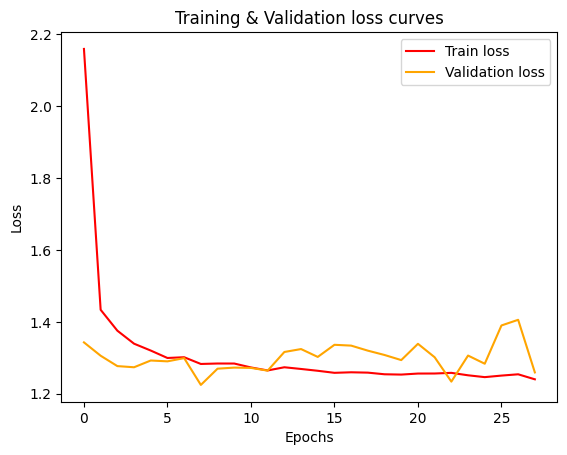

In [14]:
# Plot the loss curves
plt.plot(range(len(train_loss_history)), train_loss_history, label="Train loss", c='r')
plt.plot(range(len(val_loss_history)), val_loss_history, label="Validation loss", c='orange')

plt.title("Training & Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## 5.2 Plot accuracy history

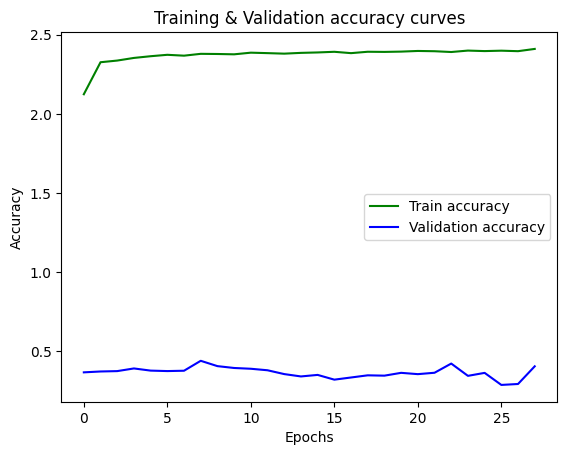

In [15]:
train_eval_history_ = [x.cpu().numpy() for x in train_eval_history]
val_eval_history_ = [x.cpu().numpy() for x in val_eval_history]
plt.plot(range(epoch+1), train_eval_history_, label="Train accuracy", c='g')
plt.plot(range(epoch+1), val_eval_history_, label="Validation accuracy", c='b')
plt.title("Training & Validation accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend();

# Make predictions

In [16]:
from utils import eval_model

def eval_model( model: torch.nn.Module, 
                test_dataloader: torch.utils.data.DataLoader, 
                loss_fn: torch.nn.Module, 
                eval_metric,
                device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")) :
    """Returns a dictionary containing the results of model predicting on data_loader.
    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on test_dataloader.
        test_dataloader (torch.utils.data.DataLoader): The target test dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        evaluation_metric: An evaluation metric (e.g., accuracy_fn) to compare the models predictions to the truth labels.
    Returns:
        (dict): Results"""
    
    test_loss_, test_eval_ = 0, 0    # variables to collect sum of loss/eval. results for all batches
    model.eval()                     # turns off various settings in model not needed for evaluation / testing
    with torch.inference_mode():     # and a couple more things behind the scenes
        for batch_id, batch_data in enumerate(test_dataloader):
            X, y = batch_data    # fetch minibatch
            X, y = X.to(device), y.to(device)  # push data to GPU
            
            y_logits = model(X)[0]    # forward pass
            y_pred_probs = torch.softmax(input=y_logits, dim=1) 
            y_preds = torch.argmax(y_pred_probs, dim=1).type(torch.float) # Go from logits -> pred labels
            
            # Calculate loss & accuracy 
            test_batch_loss = loss_fn(input=y_logits, target=y)  # loss for one batch
            test_batch_eval = eval_metric(y_preds, y)   
            
            test_loss_ += test_batch_loss.item()   # sum of losses from each batch
            test_eval_ += test_batch_eval.item() 
            
            # Calculate loss and accuracy per epoch 
            test_loss = test_loss_ / len(test_dataloader)  # sum of losses for all batches divided by the number of batches 
            test_eval = test_eval_ / len(test_dataloader)
    
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": test_loss,
            "model_eval_results": test_eval }

eval_results = eval_model(model=model, test_dataloader=test_loader, loss_fn=loss_fn, eval_metric=acc_fn, device=device)
eval_results

{'model_name': 'Reactify',
 'model_loss': 1.2776431404054165,
 'model_eval_results': 0.4060997599735856}